In [1]:
from keras import Model
from model import unet, aunet
from tqdm import tqdm
from matplotlib import pyplot as plt
import os
import numpy as np
import nibabel as nib

Using TensorFlow backend.
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hasee007

In [2]:
data_root = 'example/data'
model_path = 'example/model'
result_path = 'example/result'
mask_path = 'example/mask'

In [3]:
input_path = os.path.join(data_root, './')
method_path = os.path.join(model_path, 'unet_att.hdf5')
method_net = aunet(pretrained_weights=method_path)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
method_net.get_layer('a6').output

<tf.Tensor 'a6/up_sampling2d_1/ResizeBilinear:0' shape=(?, 20, 28, 1) dtype=float32>

In [5]:
layer_net_a6 = Model(inputs=method_net.input, outputs=method_net.get_layer('a6').output)
layer_net_a7 = Model(inputs=method_net.input, outputs=method_net.get_layer('a7').output)
layer_net_a8 = Model(inputs=method_net.input, outputs=method_net.get_layer('a8').output)

In [6]:
# min max scaler
def min_max_scaler(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))


# crop roi for unet prediction
def crop_roi(img):
    test_img = np.rot90(min_max_scaler(img))
    crop_img = test_img[130:130 + 160, 50:50 + 224]
    return crop_img

In [7]:
NII_fileList = []
for dirName, subdirList, fileList in os.walk(input_path):
    for filename in fileList:
        if ".nii" in filename.lower():
            # print filename
            NII_fileList.append(os.path.join(dirName, filename))

In [8]:
for file in tqdm(NII_fileList, desc='Detect in {}'.format(os.path.abspath(input_path))):
    filename = os.path.basename(file)
    #_, _ = detect_file(file, model, layer_net)
    data = nib.load(file)
    
    width, height, frame_num = data.shape
    matrix = data.get_data()
    #unet_matrix = bet_unet(matrix, layer_net, threshold=0.2)
    img_batch = np.transpose(matrix, (2, 0, 1))
    #mask_batch = unet_batch_predict(img_batch, layer_net, threshold=0.2)
    batch, h, w = img_batch.shape
    crop_batch = []
    for img in img_batch:
        crop_img = crop_roi(img)
        crop_batch.append(crop_img)
    crop_batch = np.array(crop_batch)
    crop_batch = np.reshape(crop_batch, crop_batch.shape + (1,))
    
    res_a6 = layer_net_a6.predict_on_batch(crop_batch)
    res_a7 = layer_net_a7.predict_on_batch(crop_batch)
    res_a8 = layer_net_a8.predict_on_batch(crop_batch)
    break

Detect in F:\GitHub\DICOM\example\data:   0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

Detect in F:\GitHub\DICOM\example\data:   0%|                                                                                                                                               | 0/4 [00:01<?, ?it/s]


In [9]:
frame_num = 17
img = crop_batch[frame_num, :, :, 0]
a6 = res_a6[frame_num, :, :, 0]
a7 = res_a7[frame_num, :, :, 0]
a8 = res_a8[frame_num, :, :, 0]

In [10]:
res_a6.shape

(30, 20, 28, 1)

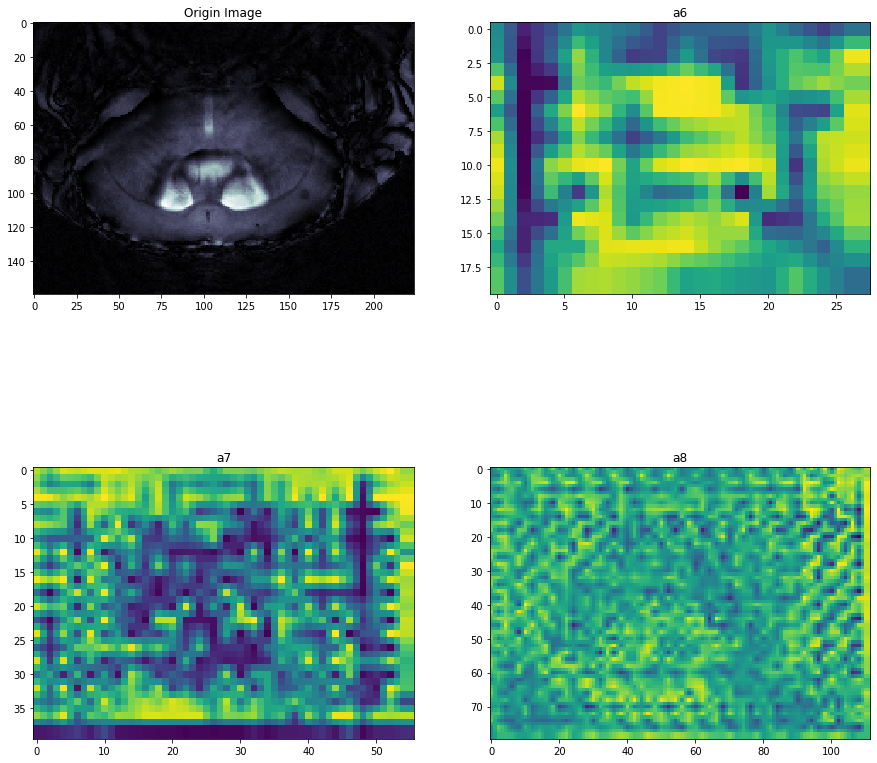

In [11]:
plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.title('Origin Image')
plt.imshow(img, cmap='bone')
plt.subplot(222)
plt.title('a6')
#plt.colorbar()
plt.imshow(a6)
plt.subplot(223)
plt.title('a7')
#plt.colorbar()
plt.imshow(a7)
plt.subplot(224)
plt.title('a8')
#plt.colorbar()
plt.imshow(a8)